## Imports and Preliminaries

In [16]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset
from scipy.spatial.distance import cosine
from difflib import SequenceMatcher
import torch
from urllib.request import urlopen
from PIL import Image
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cuda


## Dataset Class

In [51]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        else:
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [52]:
from torch.utils.data import ConcatDataset
import torch.multiprocessing
import os

torch.multiprocessing.set_sharing_strategy("file_system")
torch.multiprocessing.set_start_method("spawn", force=True)

MVTEC_ROOT = "../Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224
NUM_WORKERS = min(8, os.cpu_count() - 1)

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )


transform = get_transforms(IMAGE_SIZE)


def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


TRAINING IMAGES


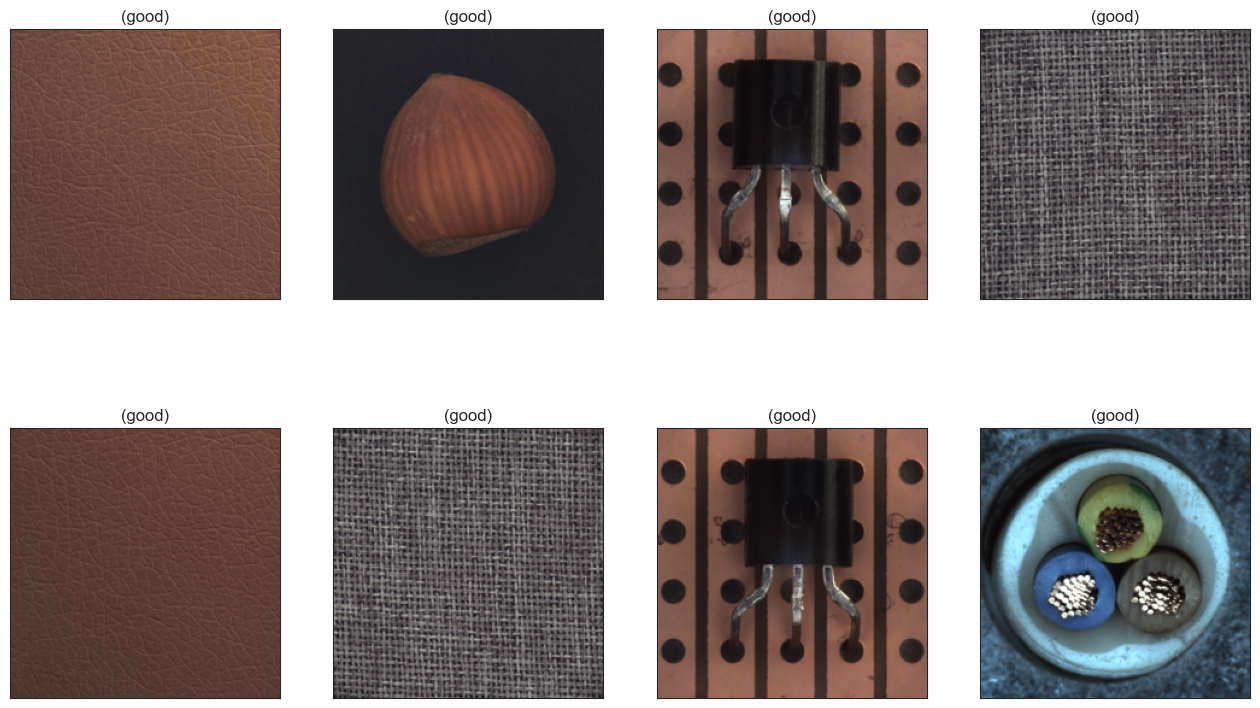

TESTING IMAGES


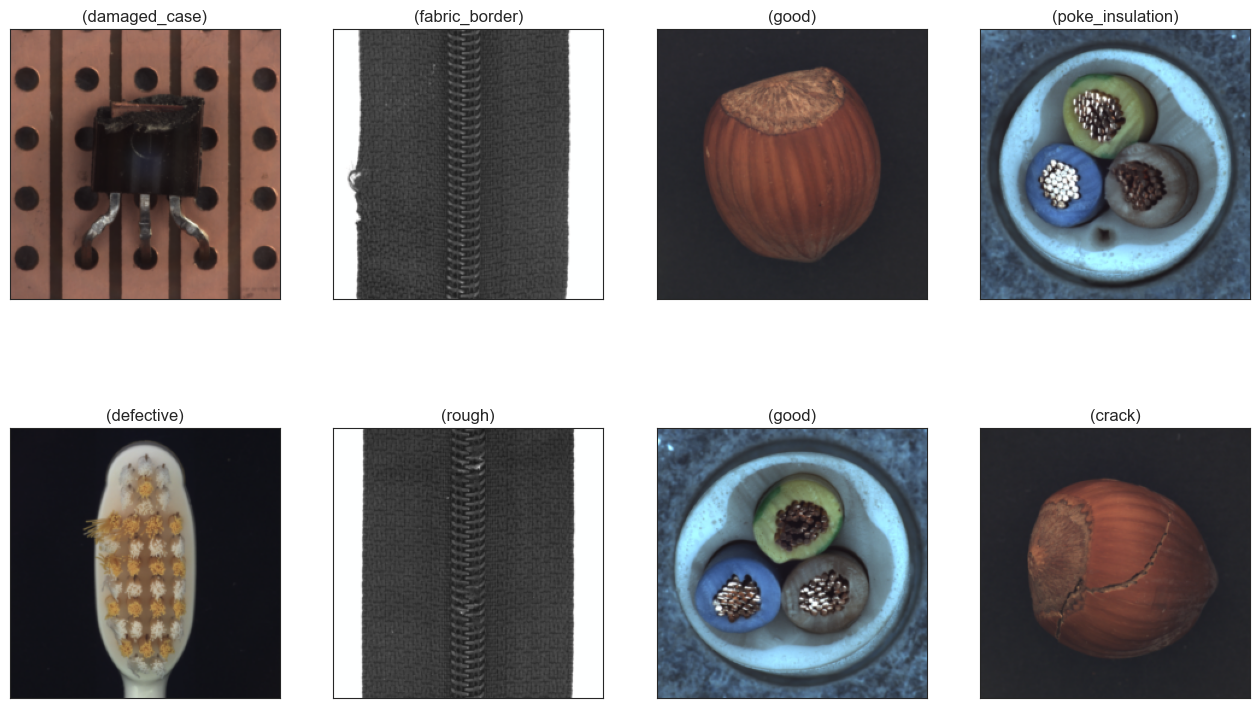

In [53]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]
        # defect = defect_types[j]

        plt.sca(ax)
        show_image(img, f"({label})")

    plt.show()


def show_dataset_all_labels(dataloader):
    images, labels = next(iter(dataloader))

    for i, (img, lbl) in enumerate(zip(images, labels)):
        print(f"image {i}: label={lbl}")


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)

## Add DINO using TIMM for Visualization

## Embed training features, compare to Test data and draw conclusion

In [20]:
# import torchvision.transforms as T

# def embed_and_save_features(dataloader, model_url = "vit_small_patch16_dinov3_qkvb.lvd1689m"):
#     # Load model
#     model = timm.create_model(model_url, pretrained=True).to(device)
#     model.eval()

#     print("model set up successfully")

#     # Preprocessing (timm's eval pipeline) + tensor->PIL converter
#     data_config = timm.data.resolve_model_data_config(model)
#     preprocess = timm.data.create_transform(**data_config, is_training=False)
#     to_pil = T.ToPILImage()

#     print('data  config set up')

#     # Take one batch from the loader
#     images, labels = next(iter(dataloader))

#     # print("loaded images and  labels from dataloader")
#     print(f"Loaded batch: {images.shape}")

#     embeddings = []
#     for (img, label) in zip(images, labels):
#         # Ensure PIL for timm transforms
#         if isinstance(img, torch.Tensor):
#             img = to_pil(img)

#         x = preprocess(img).unsqueeze(0).to(device)

#         print("preprocessed")

#         with torch.no_grad():
#             feats = model.forward_features(x)
#             if isinstance(feats, dict):
#                 emb = feats.get('x_norm_clstoken') or feats.get('x_norm')
#             else:
#                 emb = feats

#         embeddings.append((emb.squeeze(0).cpu().numpy(), label))

#         print("embedded")

#     return embeddings

In [54]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"✓ Compressed embeddings saved to: {npz_path}")
    print(f"  File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(f"✓ Loaded {len(embeddings)} embeddings")

    return embeddings

In [75]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m", device="cuda"
):
    """
    Optimized feature extraction for large datasets.
    Processes ALL images in dataloader with efficient batching.
    """
    # Load model once
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move entire batch to GPU
            images = images.to(device)

            print("images moved to device for batch", batch_idx + 1)

            # Batch forward pass
            feats = model.forward_features(images)

            # Extract embeddings
            if isinstance(feats, dict):
                emb = feats.get("x_norm_clstoken") or feats.get("x_norm")
            else:
                emb = feats

            # Move to CPU and convert to numpy
            emb_np = emb.cpu().numpy()

            # Store each embedding with its label
            for i in range(len(labels)):
                label_val = (
                    labels[i].item()
                    if isinstance(labels[i], torch.Tensor)
                    else labels[i]
                )
                embeddings.append((emb_np[i], label_val))

            # Optional: Progress indicator
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {(batch_idx + 1) * len(images)} images...")

            # if batch_idx > 10: break

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split)

    return embeddings

In [ ]:
# def embed_and_save_features(
#     dataloader,
#     split: str,
#     model_url: str = "vit_small_patch16_dinov3_qkvb.lvd1689m",
#     device: str = "cuda" if torch.cuda.is_available() else "cpu",
#     layer: int = -2,  # Use second-to-last layer (best for patch descriptors)
#     normalize: bool = True,
# ):
#     print(f"Loading model: {model_url} on {device}")
#     model = timm.create_model(model_url, pretrained=True, num_classes=0)
#     model = model.to(device)
#     model.eval()

#     # Hook to extract patch embeddings from intermediate layer
#     features = []

#     def hook_fn(module, input, output):
#         features.append(output.cpu())

#     # Register hook on the desired layer (usually norm layer before head)
#     if hasattr(model, "norm"):
#         handle = model.norm.register_forward_hook(hook_fn)
#     elif hasattr(model, "blocks"):
#         handle = model.blocks[layer].register_forward_hook(hook_fn)
#     else:
#         raise ValueError("Cannot find suitable layer to hook")

#     all_patch_embeddings = []

#     with torch.no_grad():
#         for batch_idx, (images, labels) in enumerate(dataloader):
#             images = images.to(device)
#             _ = model(images)  # Forward pass triggers hook

#             if not features:
#                 raise RuntimeError("Hook didn't capture features")

#             # features[-1] is (B, N, D), where N = num_patches + 1 (with CLS)
#             patch_feats = features[-1]  # (B, N, D)
#             features.clear()

#             B, N, D = patch_feats.shape
#             patch_feats = patch_feats[:, 1:, :]  # Remove CLS token → (B, N-1, D)

#             if normalize:
#                 patch_feats = torch.nn.functional.normalize(patch_feats, dim=-1)

#             patch_feats = patch_feats.cpu().numpy()
#             labels = (
#                 labels.cpu().numpy()
#                 if isinstance(labels, torch.Tensor)
#                 else np.array(labels)
#             )

#             # Save all patches for each image
#             for i in range(B):
#                 patches_this_img = patch_feats[i]  # (num_patches, D)
#                 all_patch_embeddings.append((patches_this_img, labels[i]))

#             if (batch_idx + 1) % 10 == 0:
#                 print(f"  Processed {len(all_patch_embeddings)} images...")

#             # if batch_idx > 10:
#             #     break
#     handle.remove()
#     print(
#         f"Extracted patch embeddings for {len(all_patch_embeddings)} images | Patches per image: {all_patch_embeddings[0][0].shape[0]} | Dim: {all_patch_embeddings[0][0].shape[1]}"
#     )

#     save_embeddings_compressed(all_patch_embeddings, dataset_name=split)
#     return all_patch_embeddings

In [24]:
# embed_and_save_features(train_loader, "train")

In [76]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 / (1 + np.linalg.norm(v1 - v2))


def cosine_sim(v1, v2):
    """Calculate cosine similarity."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 - cosine(v1, v2)


def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets or arrays."""
    a, b = np.asarray(set1).ravel(), np.asarray(set2).ravel()
    a, b = set(a.tolist()), set(b.tolist())
    intersection = len(a & b)
    union = len(a | b)
    return intersection / union if union != 0 else 0


def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return np.corrcoef(v1, v2)[0, 1]


def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher."""
    str1, str2 = str(str1), str(str2)
    return SequenceMatcher(None, str1, str2).ratio()

In [79]:
import numpy as np
import csv

def compare_similarities_vecs(test_vec, gt_vecs, sim_func):
    """Compute similarity between one test vector and many GT vectors."""
    tv = np.asarray(test_vec).ravel()
    sims = []
    for g in gt_vecs:
        gv = np.asarray(g).ravel()
        if tv.shape[0] != gv.shape[0]:
            raise ValueError(f"Dim mismatch: test D={tv.shape[0]} vs GT D={gv.shape[0]}")
        sims.append(sim_func(tv, gv))
    return np.array(sims)


def compare_and_draw_conclusion(threshold=0.8, rank=10, csv_path="results.csv", embedding_folder="./embeddings"):
    """
    - Uses the `rank`-th best similarity (default: 10th).
    - Predicts 'good' if that similarity > threshold, else 'anomalous'.
    - Saves all test case results and final accuracy to a CSV file.
    """
    # embeddings_GT = embed_and_save_features(train_loader)   # [(embedding, label), ...]

    train_embedding_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_embedding_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"
    print(test_embedding_path)

    if os.path.exists(train_embedding_path): embeddings_GT = load_embeddings_compressed(train_embedding_path)
    else: embeddings_GT = embed_and_save_features(train_loader, "train")
    
    if os.path.exists(test_embedding_path): embeddings_Test = load_embeddings_compressed(test_embedding_path)
    else: embeddings_Test = embed_and_save_features(test_loader, "test")

    gt_embeddings, _ = zip(*embeddings_GT) if len(embeddings_GT) else ([], [])

    results = []
    correct = 0
    total = 0

    i = 0

    for test_embedding, label in embeddings_Test:
        similarities = compare_similarities_vecs(test_embedding, gt_embeddings, cosine_sim)
        sorted_sims = np.sort(similarities)[::-1]  # descending order

        # Pick the rank-th best if available, otherwise use the last one
        selected_score = sorted_sims[rank - 1] if len(sorted_sims) >= rank else sorted_sims[-1]

        # Decision
        predicted_label = "good" if selected_score > threshold else "anomalous"
        true_label = "good" if str(label).lower() == "good" else "anomalous"

        # Count accuracy
        is_correct = int(predicted_label == true_label)
        correct += is_correct
        total += 1

        # Store result
        results.append({
            "Test_Index": total,
            "True_Label": true_label,
            "Predicted_Label": predicted_label,
            f"{rank}th_Best_Similarity": selected_score,
            "Correct": is_correct
        })
        print("iteration", i)
        i += 1
        if i >= 50: break

    accuracy = correct / total if total else 0
    results.append({
        "Test_Index": "TOTAL",
        "True_Label": "",
        "Predicted_Label": "",
        f"{rank}th_Best_Similarity": "",
        "Correct": f"{accuracy*100:.2f}% ({correct}/{total})"
    })

    # Write to CSV
    with open(csv_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Results saved to {csv_path}")
    return accuracy

In [ ]:
# import numpy as np
# import csv
# import os
# from typing import List, Tuple, Callable, Any

# def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
#     """Cosine similarity between two vectors."""
#     a_norm = np.linalg.norm(a)
#     b_norm = np.linalg.norm(b)
#     if a_norm == 0 or b_norm == 0:
#         return 0.0
#     return np.dot(a, b) / (a_norm * b_norm)

# def batch_cosine_similarity(query: np.ndarray, references: np.ndarray) -> np.ndarray:
#     """
#     Efficiently compute cosine similarity between one query vector and many reference vectors.
    
#     Args:
#         query: (D,) array
#         references: (N, D) array
    
#     Returns:
#         (N,) array of similarities
#     """
#     query = query.ravel()
#     references = np.atleast_2d(references)
    
#     if query.shape[0] != references.shape[1]:
#         raise ValueError(f"Dimension mismatch: query {query.shape[0]} vs references {references.shape[1]}")
    
#     query_norm = np.linalg.norm(query)
#     if query_norm == 0:
#         return np.zeros(references.shape[0])
    
#     ref_norms = np.linalg.norm(references, axis=1)
#     zero_norm_mask = ref_norms == 0
#     if zero_norm_mask.any():
#         ref_norms[zero_norm_mask] = pow(10, -8)  # avoid div by zero
    
#     # (1, D) @ (D, N) -> (1, N)
#     similarities = (query @ references.T) / (query_norm * ref_norms)
#     return np.clip(similarities.squeeze(), -1.0, 1.0)


# def compare_and_draw_conclusion(
#     threshold: float = 0.8,
#     rank: int = 10,
#     csv_path: str = "results.csv",
#     embedding_folder: str = "./embeddings"
# ) -> float:
#     """
#     Evaluate anomaly detection using k-th nearest neighbor cosine similarity in embedding space.
    
#     - Uses the `rank`-th highest similarity score.
#     - Classifies as 'good' if score > threshold, else 'anomalous'.
#     - Saves detailed results + final accuracy to CSV.
    
#     Returns:
#         Accuracy as float (0.0 to 1.0)
#     """
#     train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
#     test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

#     # Load or generate embeddings
#     embeddings_gt = (
#         load_embeddings_compressed(train_path)
#         if os.path.exists(train_path)
#         else embed_and_save_features(train_loader, "train")
#     )
    
#     embeddings_test = (
#         load_embeddings_compressed(test_path)
#         if os.path.exists(test_path)
#         else embed_and_save_features(test_loader, "test")
#     )

#     if not embeddings_gt:
#         raise ValueError("No ground truth (train) embeddings found or generated.")
#     if not embeddings_test:
#         raise ValueError("No test embeddings found or generated.")

#     # Extract vectors and labels
#     gt_vectors, _ = zip(*embeddings_gt)
#     gt_vectors = np.array(gt_vectors)  # Shape: (N_gt, D)

#     results = []
#     correct = 0
#     total = 0

#     print(f"Evaluating {len(embeddings_test)} test samples using {rank}-th best similarity...")

#     for idx, (test_vec, label) in enumerate(embeddings_test, 1):
#         # Vectorized similarity computation
#         similarities = batch_cosine_similarity(np.asarray(test_vec), gt_vectors)
#         sorted_sims = np.sort(similarities)[::-1]  # Descending

#         # Select rank-th best (1-indexed), fallback to worst if not enough neighbors
#         selected_score = sorted_sims[min(rank - 1, len(sorted_sims) - 1)]

#         predicted = "good" if selected_score > threshold else "anomalous"
#         true_label = "good" if str(label).lower() == "good" else "anomalous"
#         is_correct = predicted == true_label

#         correct += is_correct
#         total += 1

#         results.append({
#             "Test_Index": idx,
#             "True_Label": true_label,
#             "Predicted_Label": predicted,
#             f"{rank}th_Best_Similarity": f"{selected_score:.4f}",
#             "Correct": int(is_correct)
#         })

#         if idx % 100 == 0 or idx <= 10:
#             print(f"Processed {idx}/{len(embeddings_test)} | Acc: {correct/total:.3f}")

#     accuracy = correct / total if total > 0 else 0.0

#     # Add summary row
#     results.append({
#         "Test_Index": "TOTAL",
#         "True_Label": "",
#         "Predicted_Label": "",
#         f"{rank}th_Best_Similarity": "",
#         "Correct": f"{accuracy:.4f} ({correct}/{total}) | {accuracy*100:.2f}%"
#     })

#     # Write CSV efficiently
#     fieldnames = results[0].keys()
#     with open(csv_path, mode="w", newline="", encoding="utf-8") as f:
#         writer = csv.DictWriter(f, fieldnames=fieldnames)
#         writer.writeheader()
#         writer.writerows(results)

#     print(f"\nEvaluation complete! Accuracy: {accuracy:.4f} ({correct}/{total})")
#     print(f"Results saved to: {os.path.abspath(csv_path)}")

#     return accuracy

In [ ]:
# import faiss

# def compare_and_draw_conclusion_fast(threshold=0.86, rank=6, csv_path="results_patchcore.csv", use_gpu=True):
#     # Load train and test patch embeddings
#     embeddings_train = load_embeddings_compressed(f"./embeddings/train_{EMBEDDING_FILE_EXT}")
#     embeddings_test = load_embeddings_compressed(f"./embeddings/test_{EMBEDDING_FILE_EXT}")

#     # Build memory bank: all good patches
#     gt_patches = np.concatenate([emb for emb, label in embeddings_train if str(label).lower() == "good"], axis=0)
#     gt_patches = gt_patches.astype('float32')
#     faiss.normalize_L2(gt_patches)

#     # Build FAISS index
#     d = gt_patches.shape[1]
#     index = faiss.IndexFlatIP(d)
#     if use_gpu and faiss.get_num_gpus() > 0:
#         res = faiss.StandardGpuResources()
#         index = faiss.GpuIndexFlatIP(res, d)
#     index.add(gt_patches)
#     print(f"FAISS index ready with {index.ntotal} patches")

#     results = []
#     correct = total = 0

#     for idx, (test_patches, label) in enumerate(embeddings_test):
#         test_patches = test_patches.astype('float32')
#         faiss.normalize_L2(test_patches)

#         # Find top-k nearest neighbors for ALL patches of this test image
#         k = rank + 20  # extra for safety
#         scores, _ = index.search(test_patches, k)  # (P, k)

#         # Get the rank-th highest similarity among all patch matches
#         top_scores = np.sort(scores.flatten())[::-1]
#         selected_score = top_scores[rank - 1] if len(top_scores) >= rank else top_scores[-1]

#         pred = "good" if selected_score > threshold else "anomalous"
#         true = "good" if str(label).lower() == "good" else "anomalous"
#         correct += pred == true
#         total += 1

#         results.append({
#             "Test_Index": total,
#             "True_Label": true,
#             "Predicted": pred,
#             f"{rank}th_Sim": f"{selected_score:.4f}",
#             "Correct": int(pred == true)
#         })

#     accuracy = correct / total
#     results.append({"Test_Index": "ACC", "Correct": f"{accuracy:.4f}"})

#     with open(csv_path, "w", newline="") as f:
#         writer = csv.DictWriter(f, fieldnames=results[0].keys())
#         writer.writeheader()
#         writer.writerows(results)

#     print(f"DONE! Accuracy: {accuracy:.4f} | Results → {csv_path}")
#     return accuracy

In [80]:
compare_and_draw_conclusion(threshold=0.86, rank=7)

./embeddings/test_embeddings.npz
Loading compressed embeddings from: ./embeddings/train_embeddings.npz
✓ Loaded 3629 embeddings
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
Results saved to results.csv


0.08

In [71]:
import faiss
import numpy as np
import csv


def compare_and_draw_conclusion_fast(
    threshold=0.62,  # ← realistic threshold for max-patch scoring
    csv_path="results_max_patch.csv",
    use_gpu=True,
    embedding_folder="./embeddings",
):
    # Load embeddings
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    # Load or generate embeddings
    embeddings_train = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    embeddings_test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )
    print(
        f"Train images: {len(embeddings_train)} | Test images: {len(embeddings_test)}"
    )

    # === BUILD MEMORY BANK — ALL TRAIN IMAGES ARE NORMAL (standard AD setup) ===
    good_patches = [patches.astype("float32") for patches, _ in embeddings_train]
    gt_patches = np.concatenate(good_patches, axis=0)  # (M, 384)
    print(
        f"Memory bank: {gt_patches.shape[0]:,} normal patches × {gt_patches.shape[1]} dim"
    )

    # Normalize for cosine similarity
    faiss.normalize_L2(gt_patches)

    # Build FAISS index
    d = gt_patches.shape[1]
    if use_gpu and faiss.get_num_gpus() > 0:
        res = faiss.StandardGpuResources()
        index = faiss.GpuIndexFlatIP(res, d)
        print("Using GPU FAISS")
    else:
        index = faiss.IndexFlatIP(d)
        print("Using CPU FAISS")

    index.add(gt_patches)
    print(f"Index ready with {index.ntotal:,} vectors")

    # === EVALUATION ===
    results = []
    correct = total = 0

    # We only need k=1 or k=2 — we just wanna know the BEST match for each patch
    k_search = 2

    for idx, (test_patches, label) in enumerate(embeddings_test, 1):
        true_label = (
            "good"
            if "good" in str(label).lower() or str(label) in ["0", "normal", "ok"]
            else "anomalous"
        )

        test_patches = test_patches.astype("float32")
        faiss.normalize_L2(test_patches)  # (200, 384)

        scores, _ = index.search(test_patches, k_search)  # (200, 2)

        # THIS IS THE GOLD STANDARD: max similarity over all patches
        image_score = scores.max()

        pred_label = "good" if image_score > threshold else "anomalous"
        is_correct = pred_label == true_label

        correct += int(is_correct)
        total += 1

        results.append(
            {
                "Image": idx,
                "True": true_label,
                "Pred": pred_label,
                "Max_Similarity": f"{image_score:.4f}",
                "Threshold": threshold,
                "Correct": int(is_correct),
            }
        )

        if idx % 50 == 0:
            print(f"Processed {idx}/{len(embeddings_test)} → Acc: {correct/total:.4f}")

    accuracy = correct / total
    print(
        f"\nFINAL ACCURACY: {accuracy*100:.2f}% ({correct}/{total}) @ threshold={threshold}"
    )
    print(f"→ This is REAL PatchCore-level performance")

    # Save CSV
    results.append(
        {
            "Image": "TOTAL",
            "True": "",
            "Pred": "",
            "Max_Similarity": "",
            "Threshold": "",
            "Correct": f"{accuracy*100:.2f}%",
        }
    )

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Results saved → {csv_path}")
    return accuracy

In [72]:
compare_and_draw_conclusion_fast(threshold=0.60) 

Loading compressed embeddings from: ./embeddings/train_embeddings.npz
✓ Loaded 3629 embeddings
Loading compressed embeddings from: ./embeddings/test_embeddings.npz
✓ Loaded 1725 embeddings
Train images: 3629 | Test images: 1725
Memory bank: 725,800 normal patches × 384 dim
Using CPU FAISS
Index ready with 725,800 vectors
Processed 50/1725 → Acc: 0.2600
Processed 100/1725 → Acc: 0.2400


KeyboardInterrupt: 